In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.tools import MMSeqs
from sklearn.metrics import r2_score, euclidean_distances
from src.dataset import Dataset
from src.graph import NeighborsGraph
from src.embed.embedders.plm import ESMEmbedder
from src.files import FASTAFile
from src.classifier import Classifier
from src.distance import DistanceMatrix
import itertools
from src.tools import MMSeqs
from utils import *
import os
import mplcursors
from matplotlib.lines import Line2D
import matplotlib as mpl

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [42]:
model_name = 'model_v2'
model = Classifier.load('../models/model_v2.pkl')

train_results_df = pd.read_csv('../data/results/dataset_train_predict.csv', index_col=0).assign(dataset='train')
test_results_df = pd.read_csv('../data/results/dataset_test_predict.csv', index_col=0).assign(dataset='test')

results_df = pd.concat([train_results_df, test_results_df])
results_df = results_df.merge(pd.read_csv('../data/dataset/dataset.csv', index_col=0), left_index=True, right_index=True)
results_df = results_df.rename(columns={f'{model_name}_output_0':'model_output_0', f'{model_name}_output_1':'model_output_1', f'{model_name}_label':'model_label'})[['model_label', 'model_output_0', 'model_output_1', 'dataset']].copy()
results_df = results_df.merge(pd.read_csv('../data/dataset/dataset.csv', index_col=0), left_index=True, right_index=True)
results_df = apply_thresholds(results_df, real_threshold=0.8, spurious_threshold=0.95)


In [43]:
def table_1(results_df:pd.DataFrame, ignore_uncertain:bool=False):

    annotated_results_df = pd.read_csv('../data/results/dataset_false_negative_annotated.csv', index_col=0)
    fragment_ids = annotated_results_df[(annotated_results_df.category == 'fragment')].index.values # Remove the known fragments.


    results_df = results_df[(results_df.label == 1)].copy() # Looking only at real-labeled sequences.
    results_df = results_df[~results_df.index.isin(fragment_ids)].copy()

    table_df = pd.DataFrame(index=pd.Series(results_df['product'].unique(), name='family'))
    table_df = table_df[table_df.index != 'Uncharacterized protein'].copy()
    table_df['size'] = results_df.groupby('product').size()
    table_df['singleton'] = table_df['size'] == 1
    table_df['n_real'] = results_df.groupby('product').real.sum()
    table_df['n_spurious'] = results_df.groupby('product').spurious.sum()
    table_df['n_uncertain'] = results_df.groupby('product').uncertain.sum()
    table_df['homogeneity'] = table_df.n_real / table_df['size'] if (not ignore_uncertain) else (table_df.n_real + table_df.n_uncertain) / table_df['size']

    print('table: Num. annotated protein families:', len(table_df))
    print('table: Num. non-singleton annotated protein families:', (~table_df.singleton).sum())
    print('table: Num. non-homogenous annotated protein families:', (table_df.homogeneity < 1).sum(),f'({get_percent((table_df.homogeneity < 1).sum(), (~table_df.singleton).sum())})' )

    table_df = table_df[(table_df['size'] > 10) & (table_df.homogeneity < 1)]
    table_df = table_df.sort_values('size', ascending=False)
    table_df = table_df[table_df['n_spurious'] > 0].copy()

    save_table(table_df[['n_real', 'n_spurious', 'n_uncertain']], label='results_1.3-table_1')

table_1(results_df)

table: Num. annotated protein families: 34762
table: Num. non-singleton annotated protein families: 7245
table: Num. non-homogenous annotated protein families: 665 (9.18%)


,n_real,n_spurious,n_uncertain
family,,,
DNA-directed RNA polymerase subunit omega,395,5,29
D-aminoacyl-tRNA deacylase,383,4,9
Putative membrane protein insertion efficiency factor,257,11,101
Probable RNA 2'-phosphotransferase,40,1,0
Flagellar transcriptional regulator FlhD,39,1,0
Beta-lactamase,36,1,0
Anti-adapter protein IraM,9,2,2


In [44]:
rpoz_results_df = results_df[results_df['product'] == 'DNA-directed RNA polymerase subunit omega'].copy()
rpoz_results_df.to_csv('../data/results/results-1/rpoz.csv')
FASTAFile(df=rpoz_results_df).write('../data/results/results-1/rpoz.faa')
# rpoz_dataset = Dataset.from_hdf('../data/results/rpoz/rpoz.h5')

In [45]:
def get_amino_acid_composition(df:pd.DataFrame):
    df = df.copy()
    amino_acids = sorted(list('ACDEFGHIKLMNPQRSTVWY'))  
    aa_comp_df = [{aa:seq.count(aa) / len(seq) for aa in list(amino_acids)} for seq in df.seq]
    aa_comp_df = pd.DataFrame(aa_comp_df, index=df.index)[amino_acids]
    return aa_comp_df, amino_acids

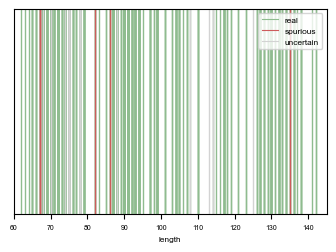

In [ ]:
def figure_1(results_df:pd.DataFrame, path:str='../figures/results-1.si1_figure-1.pdf'):
    
    fig, ax = get_figure(n_cols=1)

    ax_df = results_df.copy()
    ax_df['length'] = ax_df.seq.apply(len)

    spurious_ids = results_df[results_df.spurious].index
    real_ids = results_df[results_df.real].index
    uncertain_ids = results_df[results_df.uncertain].index

    # sns.kdeplot(ax_df.loc[real_ids], x='length', color='darkseagreen')
    for length in ax_df.loc[real_ids].length:
        ax.axvline(length, ls='-', color='darkseagreen', lw=1) 
    for length in ax_df.loc[uncertain_ids].length:
        ax.axvline(length, ls='-', color='lightgray', lw=1) 
    for length in ax_df.loc[spurious_ids].length:
        ax.axvline(length, ls='-', color='indianred', lw=1) 

    # Make a custom legend. 
    handles = list()
    handles += [Line2D([0], [0], color='darkseagreen', label=f'real', ls='-')]
    handles += [Line2D([0], [0], color='indianred', label=f'spurious', ls='-')]
    handles += [Line2D([0], [0], color='lightgray', label=f'uncertain', ls='-')]

    ax.legend(handles=handles, loc='upper right')

    ax.set_xlabel('length')
    ax.set_yticks([])
    ax.set_xlim(xmax=145, xmin=60)
    
    save_figure(fig, path=path)

# I realize this is not the best way to show a length distribution, but I wanted to get individual-level resolution
# in case very small length differences are obscured by a KDE. 
figure_1(rpoz_results_df)

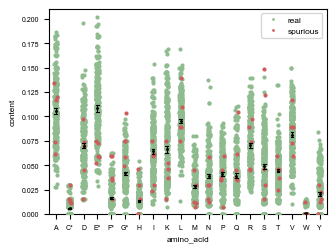

In [ ]:
def figure_2(results_df:pd.DataFrame, path:str='../figures/results-1.si1_figure-2.pdf'):
    
    fig, ax = get_figure()

    # ax_df is a DataFrame with a column for each amino acid, and values represent the normalized content in each sequence.
    ax_df, amino_acids = get_amino_acid_composition(results_df)

    spurious_ids = results_df[results_df.spurious].index
    real_ids = results_df[results_df.real].index

    for i, amino_acid in enumerate(amino_acids): # Don't think I can or should assume normality, so probably best to use Mann-Whitney
        p = get_mann_whitney_p_value(ax_df.loc[spurious_ids][amino_acid].values, ax_df.loc[real_ids][amino_acid].values, n_permutations=1000)
        if (p < 0.05):
            amino_acids[i] = amino_acids[i] + '*'

    ax.set_xticks(np.arange(len(amino_acids)), labels=amino_acids)
    sns.stripplot(data=ax_df.loc[real_ids], ax=ax, color='darkseagreen', size=mpl.rcParams.get('lines.markersize'))
    sns.stripplot(data=ax_df.loc[spurious_ids], ax=ax, color='indianred', size=mpl.rcParams.get('lines.markersize'))
    sns.pointplot(data=ax_df.loc[real_ids], ax=ax, c='black', linestyle='none', err_kws={'linewidth':0.8}, capsize=0.2, zorder=10, markersize=1)

    # Make a custom legend. 
    handles = list()
    handles += [Line2D([0], [0], marker='o', color='w', markerfacecolor='darkseagreen', label=f'real', markersize=mpl.rcParams.get('lines.markersize'))]
    handles += [Line2D([0], [0], marker='o', color='w', markerfacecolor='indianred', label=f'spurious', markersize=mpl.rcParams.get('lines.markersize'))]

    ax.legend(handles=handles, loc='upper right')

    ax.set_ylim(ymax=0.21, ymin=0)
    ax.set_ylabel('content')
    ax.set_xlabel('amino_acid')

    save_figure(fig, path=path)

figure_2(rpoz_results_df)

In [8]:
mmseqs = MMSeqs()
rpoz_align_df = mmseqs.align(rpoz_results_df, query_name='rpoz', output_dir='../data/results/results-1/')
rpoz_dataset = Dataset.from_hdf('../data/results/results-1/rpoz.h5')

DistanceMatrix.from_alignment: Removing 0 duplicate query-subject pairs.


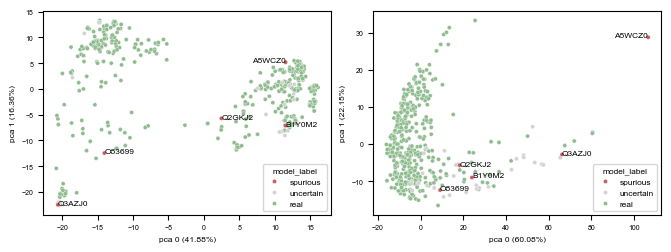

In [ ]:
def figure_3(results_df:pd.DataFrame, align_df:pd.DataFrame, dataset:Dataset, path:str='../figures/results-1.si1_figure-3.pdf'):

    fig, (ax_a, ax_b) = get_figure(n_cols=2) 
    palette = {'real':'darkseagreen', 'spurious':'indianred', 'uncertain':'lightgray'}

    spurious_ids = results_df[results_df.spurious].index

    for ax, matrix in zip([ax_a, ax_b], [DistanceMatrix.from_alignment(align_df), DistanceMatrix.from_dataset(dataset, scale=False, metric='cosine')]):

        ax_df, (var_0, var_1) = get_pca(matrix.to_df(melt=False))
        ax_df['model_label'] = ax_df.index.map(results_df.model_label)
        ax_df['model_label'] = pd.Categorical(ax_df.model_label, ordered=True, categories=['spurious', 'uncertain', 'real'])
        ax_df = ax_df.sort_values('model_label', ascending=False)
        sns.scatterplot(ax_df, ax=ax, x=0, y=1, hue='model_label', palette=palette)
        ax.set_ylabel(f'pca 1 ({100 * var_1:.2f}%)')
        ax.set_xlabel(f'pca 0 ({100 * var_0:.2f}%)')

        for row in ax_df.loc[spurious_ids].itertuples():
            ax.text(row._1, row._2, row.Index, ha='right' if (row.Index == 'A5WCZ0') else 'left')

    save_figure(fig, path)

figure_3(rpoz_results_df, rpoz_align_df, rpoz_dataset)

# I wonder if any of the other PCA components pick up a signal which separates the real from spurious. 

In [ ]:
def get_alignments(align_df:pd.DataFrame, query_id:str, subject_ids:list=None, min_bit_score:float=None):
    '''Get all alignments between the query sequence and specified subject IDs.'''
    subject_ids = align_df.subject_id.unique() if (subject_ids is None) else subject_ids

    assert np.all(np.sort(align_df.query_id.unique()) == np.sort(align_df.subject_id.unique())), 'get_alignments: Expected symmetrical alignments.'
    align_df = align_df[(align_df.query_id == query_id) & align_df.subject_id.isin(subject_ids)].copy()
    if min_bit_score is not None:
        align_df = align_df[align_df.bit_score > min_bit_score].copy()
    return align_df.sort_values('bit_score', ascending=False)

spurious_ids = rpoz_results_df[rpoz_results_df.spurious].index.values 
real_ids = rpoz_results_df[rpoz_results_df.real].index.values 

for query_id in spurious_ids:
    df = get_alignments(rpoz_align_df, query_id, subject_ids=real_ids, min_bit_score=50).rename(columns={'subject_seq':'seq'}).set_index('subject_id')
    print(f'Num. significant (bit_score > 50) alignments for {query_id}:', len(df))


print()
for query_id in ['B1Y0M2', 'A5WCZ0', 'Q2GKJ2']:
    df = get_alignments(rpoz_align_df, query_id, subject_ids=real_ids, min_bit_score=100).rename(columns={'subject_seq':'seq'}).set_index('subject_id')
    print(f'Num. strong alignments (bit_score > 100) for {query_id}:', len(df))
    FASTAFile(df=df).write(f'../data/results/results-1/{query_id.lower()}.faa')

# All strong alignments to B1Y0M2 are length 67. 
b1y0m2_align_df = get_alignments(rpoz_align_df, 'B1Y0M2', subject_ids=real_ids, min_bit_score=100).rename(columns={'subject_seq':'seq'}).set_index('subject_id')

# ! ~/muscle5.1.linux_intel64 -align '../data/results/rpoz/b1y0m2.faa' -output '../data/results/rpoz/b1y0m2.afa'
# ! ~/muscle5.1.linux_intel64 -align '../data/results/rpoz/a5wcz0.faa' -output '../data/results/rpoz/a5wcz0.afa'

Num. significant (bit_score > 50) alignments for B1Y0M2: 214
Num. significant (bit_score > 50) alignments for Q3AZJ0: 15
Num. significant (bit_score > 50) alignments for A5WCZ0: 213
Num. significant (bit_score > 50) alignments for O83699: 0
Num. significant (bit_score > 50) alignments for Q2GKJ2: 71

Num. strong alignments (bit_score > 100) for B1Y0M2: 18
Num. strong alignments (bit_score > 100) for A5WCZ0: 3
Num. strong alignments (bit_score > 100) for Q2GKJ2: 2


In [11]:
def get_mutations(seq:str, n:int=2, mutations:dict=None, id_:str='B1Y0M2'):

    def mutate(seq:str, mutations:list):
        '''Apply a list of mutations, defined by (position, amino_acid), to the sequence.'''
        for position, amino_acid in mutations:
            seq = seq[:position] + amino_acid + seq[position + 1:]
        return seq
    
    seqs, ids = list(), list()
    # Generate every combination of n positions. 
    for positions in itertools.combinations(mutations.keys(), n):
        mutations_subset = {position:mutations[position] for position in positions} # Get a subset of the mutations corresponding to the selected positions. 
        mutations_subset = [[(position, amino_acid) for amino_acid in amino_acids] for position, amino_acids in mutations_subset.items()]
        # Select one mutation for each position being mutated, in every possible combination (the Cartesian product.). 
        for mutations_ in itertools.product(*mutations_subset):
            mutation_id = f'{id_}_' + '_'.join([f'{position}{amino_acid}' for position, amino_acid in sorted(mutations_, key=lambda m : m[0])])
            ids.append(mutation_id)
            seqs.append(mutate(seq, mutations_))
    return pd.DataFrame({'seq':seqs, 'id':ids}).set_index('id')

In [12]:
# Mutate all K values at position 62 to an R. 

b1y0m2_mutations = dict()
b1y0m2_mutations[5] = ['I']
b1y0m2_mutations[10] = ['E', 'K']
b1y0m2_mutations[11] = ['Q', 'H']
b1y0m2_mutations[17] = ['E']
b1y0m2_mutations[19] = ['T', 'A']
b1y0m2_mutations[21] = ['S', 'C']
b1y0m2_mutations[28] = ['Q']
b1y0m2_mutations[30] = ['L', 'A', 'V']
b1y0m2_mutations[34] = ['T']
b1y0m2_mutations[35] = ['A']
b1y0m2_mutations[36] = ['R']
b1y0m2_mutations[37] = ['I']
b1y0m2_mutations[38] = ['D']
b1y0m2_mutations[39] = ['S', 'A', 'C']
b1y0m2_mutations[40] = ['R']
b1y0m2_mutations[41] = ['D']
b1y0m2_mutations[44] = ['T', 'A']
b1y0m2_mutations[46] = ['I', 'V']
b1y0m2_mutations[53] = ['E', 'S']
b1y0m2_mutations[55] = ['K', 'H', 'Q', 'L']
b1y0m2_mutations[56] = ['I']
b1y0m2_mutations[58] = ['L', 'V']
b1y0m2_mutations[62] = ['K']
b1y0m2_mutations[66] = ['S', 'V', 'N', 'A', 'T']


b1y0m2_seq = 'MARITVEDCLQKIPNRFQLVLAATYRARMLSQGHAPKVETKNKPGVTALREIAAGAVGIEMLRKVPG'
b1y0m2_df = pd.concat([get_mutations(b1y0m2_seq, n=2, mutations=b1y0m2_mutations), get_mutations(b1y0m2_seq, n=1, mutations=b1y0m2_mutations)])

if not os.path.exists('../data/results/results-1/b1y0m2.h5'):
    embedder = ESMEmbedder(model_size='650m')
    b1y0m2_embeddings = embedder(b1y0m2_df.seq)
    b1y0m2_dataset = Dataset(embedding=b1y0m2_embeddings, index=b1y0m2_df.index)
    b1y0m2_dataset.to_hdf('../data/results/results-1/b1y0m2.h5')

if not os.path.exists('../data/results/results-1/b1y0m2_results.csv'):
    model = Classifier.load('../models/model_v2.pkl')
    b1y0m2_dataset = Dataset.from_hdf('../data/results/results-1/b1y0m2.h5')
    model.scale(b1y0m2_dataset, fit=False)
    model_labels, model_outputs = model.predict(b1y0m2_dataset, include_outputs=True)
    b1y0m2_results_df = pd.DataFrame({'model_label':model_labels, 'model_output_0':model_outputs.T[0], 'model_output_1':model_outputs.T[1]}, index=b1y0m2_dataset.index)
    b1y0m2_results_df.to_csv('../data/results/results-1/b1y0m2_results.csv')

b1y0m2_results_df = pd.read_csv('../data/results/results-1/b1y0m2_results.csv', index_col=0)
b1y0m2_results_df = apply_thresholds(b1y0m2_results_df)

In [13]:
b1y0m2_real_ids = b1y0m2_results_df[b1y0m2_results_df.model_label == 'real'].index
b1y0m2_dataset = Dataset.from_hdf('../data/results/results-1/b1y0m2.h5')
b1y0m2_rpoz_dataset = rpoz_dataset.concat(b1y0m2_dataset)
b1y0m2_rpoz_results_df = pd.concat([rpoz_results_df, b1y0m2_results_df])

Dataset.from_hdf: No metadata stored in the Dataset at ../data/results/results-1/b1y0m2.h5


In [ ]:

def figure_4(results_df:pd.DataFrame, dataset:Dataset, ids:list=None, path:str='../figures/results-1.si1_figure-4.pdf', interactive:bool=False):

    fig, ax = get_figure()
    palette = {'real':'darkseagreen', 'spurious':'indianred', 'uncertain':'lightgray', 'none':'gray'}

    matrix = DistanceMatrix.from_dataset(dataset, scale=False)
    ax_df, (var_0, var_1) = get_pca(matrix.to_df(melt=False))
    ax_df['mutated'] = ax_df.index.str.contains('_')
    ax_df['id'] = ax_df.index
    ax_df['model_label'] = ax_df.index.map(results_df.model_label)
    ax_df['model_label'] = ax_df.model_label.fillna('none')
    ax_df['model_label'] = pd.Categorical(ax_df.model_label, ordered=True, categories=['spurious', 'uncertain', 'real'])
    ax_df = ax_df.sort_values('model_label', ascending=False)

    sns.scatterplot(ax_df[~ax_df.mutated], ax=ax, x=0, y=1, hue='model_label', palette=palette, alpha=0.3, legend=False)
    ax_ = sns.scatterplot(ax_df[ax_df.mutated], ax=ax, x=0, y=1,  hue='model_label', palette=palette)
    sns.scatterplot(ax_df.loc[ids], ax=ax, x=0, y=1, color='black')

    ax.set_ylabel(f'pca 1 ({100 * var_1:.2f}%)')
    ax.set_xlabel(f'pca 0 ({100 * var_0:.2f}%)')

    for row in ax_df.loc[ids].itertuples():
            ax.text(row._1, row._2, row.Index)

    if interactive:
        ax_df_ = ax_df[ax_df.mutated].copy()
        artist = ax_.collections[1]
        cursor = mplcursors.cursor(artist, hover=True)
        @cursor.connect('add')
        def annotate(sel):
            label = ax_df_.iloc[sel.index]['id'] # Get label from your filtered dataframe based on closest point found
            sel.annotation.set_text(label)
            sel.annotation.get_bbox_patch().set(fc='white', alpha=0.9)
    else:
         save_figure(fig, path=path)

# %matplotlib widget
%matplotlib inline
figure_4(b1y0m2_rpoz_results_df, b1y0m2_rpoz_dataset, ids=rpoz_results_df[rpoz_results_df.spurious].index, interactive=False)